In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

from keras.models import load_model

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

C:\Users\LeeDongYeun\AppData\Local\conda\conda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\LeeDongYeun\AppData\Local\conda\conda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\LeeDongYeun\AppData\Local\conda\conda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\User

In [3]:
dataPath = 'Data/entity-annotated-corpus/ner_dataset.csv'

In [4]:
data = pd.read_csv(dataPath, encoding="latin1")

In [5]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [7]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [8]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [9]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [10]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [11]:
data = data.fillna(method="ffill")

In [12]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [13]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [14]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [15]:
data[:30]

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,london,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [16]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [17]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [18]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [19]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


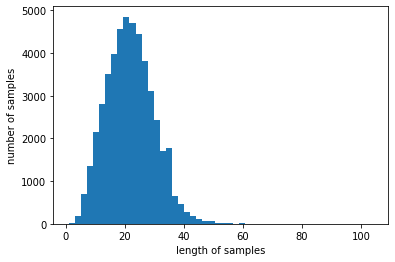

In [20]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [22]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [23]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [24]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [25]:
print(X_train[0])
print(y_train[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [44]:
word_to_index = src_tokenizer.word_index

def texts_to_sequences(sentences, word_to_index):
    seq_list = []
    for sentence in sentences:
        new_X = []
        for w in sentence:
            try:
              new_X.append(word_to_index.get(w,1))
            except KeyError:
              new_X.append(word_to_index['OOV'])
        
        seq_list.append(new_X)
    
    return seq_list
        
        
def make_index_list(text, word_to_index):
    max_len = 70
    indexed_list = []
    for sentence in text:
        new_sentence = sentence.lower().split()

        new_X=[]
        for w in new_sentence:
            try:
              new_X.append(word_to_index.get(w,1))
            except KeyError:
              new_X.append(word_to_index['OOV'])

        pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)
        indexed_list.append(pad_new[0])
    return indexed_list

In [45]:
seq = texts_to_sequences(sentences, word_to_index)

In [46]:
seq[0]

[254,
 6,
 967,
 16,
 1795,
 238,
 468,
 7,
 523,
 2,
 129,
 5,
 61,
 9,
 571,
 2,
 833,
 6,
 186,
 90,
 22,
 15,
 56,
 3]

In [26]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word
index_to_ner[0]='PAD'

In [27]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [28]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [29]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [32]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [33]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


In [35]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit(X_train, y_train, batch_size=64, epochs=6, validation_split=0.1, verbose=1)

C:\Users\LeeDongYeun\AppData\Local\conda\conda\envs\keras2\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\LeeDongYeun\AppData\Local\conda\conda\envs\keras2\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '



Train on 34530 samples, validate on 3837 samples
Epoch 1/6


KeyboardInterrupt: 

In [35]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

9592/9592 [==============================] - 55s 6ms/step

 테스트 정확도: 0.9591


In [36]:
model.save_weights('bi_lstm_crf_weight.h5')

In [37]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


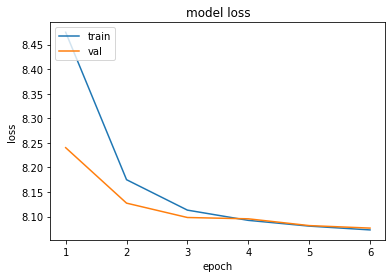

In [38]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [30]:
def sequences_to_tag(sequences): # 예측값을 index_to_tag를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [38]:
model = a

In [42]:
y_predicted = model.predict(X_test)
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [36]:
test_tags = sequences_to_tag(y_test)

In [39]:
len(test_tags[0])

70

In [43]:
print(classification_report(test_tags, pred_tags))

           precision    recall  f1-score   support

      org       0.68      0.56      0.61      4033
      geo       0.81      0.87      0.84      7620
      tim       0.85      0.85      0.85      4067
      per       0.80      0.75      0.77      3545
      gpe       0.96      0.94      0.95      3145
      art       0.00      0.00      0.00        63
      eve       0.00      0.00      0.00        52
      nat       0.00      0.00      0.00        37

micro avg       0.82      0.79      0.81     22562
macro avg       0.81      0.79      0.80     22562



In [44]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 80.7%


In [132]:
word_to_index = src_tokenizer.word_index
new_sentence='Hong Gildong starts over with the Justice League of Joseon at the country of Yul'.split()
new_sentence='the white house said in a statement'.split()
new_sentence='the fbi has determined that north korea was behind the hack on sony , confirming widespread suspicions pointing to the north that has expressed strong anger at a sony movie , " the interview , " which involves a plot to assassinate north korean leader kim_jong_un.'.split()
new_sentence='tension between the united states and north korea further escalated over the weekend as washington imposed new economic sanctions friday against pyongyang in retaliation for the reclusive regime ’s alleged cyberattack on sony pictures entertainment'.split()
new_sentence='The United States announced retaliatory sanctions on North Korea on Friday in response to the communist nation \'s alleged cyber-attacks on Sony Pictures, warning the actions are just the  " first aspect "  of its response .'.lower().split()

In [133]:
new_X=[]
for w in new_sentence:
    try:
      new_X.append(word_to_index.get(w,1))
    except KeyError:
      new_X.append(word_to_index['OOV'])
      # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩

print(new_X)

[2, 52, 70, 255, 13271, 528, 13, 131, 243, 13, 82, 5, 892, 7, 2, 947, 356, 10, 497, 1, 13, 6706, 1, 906, 2, 1758, 30, 392, 2, 31, 101, 20807, 31, 6, 45, 892, 3]


In [134]:
pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)

In [159]:
p = model.predict(np.array([pad_new[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("단어", "예측값"))
print(30 * "=")
for w, pred in zip(new_sentence, p[0]):
    print("{:15}: {:5}".format(w, index_to_ner[pred]))


단어             ||예측값
on             : O    
friday         : B-tim
,              : O    
scott          : B-per
borg           : I-per
,              : O    
director       : O    
and            : O    
chief          : O    
economist      : O    
of             : O    
the            : O    
u.s.           : B-geo
cyber          : O    
consequences   : O    
unit           : O    
,              : O    
an             : O    
independent    : O    
,              : O    
nonprofit      : B-org
research       : I-org
institute      : I-org
specializing   : I-org
on             : O    
cyber-threats  : B-geo
and            : O    
risks          : O    
,              : O    
also           : O    
said           : O    
in             : O    
a              : O    
commentary     : O    
on             : O    
the            : O    
cnbc           : B-org
website        : O    
that           : O    
the            : O    
skills         : O    
employed       : O    
in           

In [188]:
def process_ner(sentence, bio):
    
    joined = []
    for w, pred in zip(sentence, bio):
        joined.append((w,pred))
    
    i = 0
    ner_list = []
    while i < len(joined):
        if joined[i][1] != 0 and joined[i][1] != 1:
            ner = []
            ner.append(joined[i])
            i += 1

            while joined[i][1] != 0 and joined[i][1] != 1:
                ner.append(joined[i])
                i += 1
            
            word = " ".join([x[0] for x in ner])
            entity = ner[0][1]
#             entity = index_to_ner[ner[0][1]]
            ner_list.append((word, entity))
        else:
            i += 1
    
    return ner_list

In [189]:
process_ner(new_sentence, p[0])

[('friday', 3),
 ('scott borg', 6),
 ('u.s.', 2),
 ('nonprofit research institute specializing', 4),
 ('cyber-threats', 2),
 ('cnbc', 4),
 ('sony hack', 4)]

In [152]:
joined = []
for w, pred in zip(new_sentence, p[0]):
    joined.append((w,pred))

In [169]:
i = 0
ner_list = []
while i < len(joined):
    x = joined[i]
    
    if x[1] != 0 and x[1] != 1:
        ner = []
        ner.append(x)
        i += 1
        
        while joined[i][1] != 0 and joined[i][1] != 1:
            ner.append(joined[i])
            i += 1
            
        word = " ".join([x[0] for x in ner])
        entity = ner[0][1]
        
        ner_list.append((word, entity))
    else:
        i += 1

print(ner_list)

[('friday', 3), ('scott borg', 6), ('u.s.', 2), ('nonprofit research institute specializing', 4), ('cyber-threats', 2), ('cnbc', 4), ('sony hack', 4)]


In [153]:
for ner in ner_list:
    word = " ".join([x[0] for x in ner])
    entity = ner[0][1]
    
    print(word, entity)
        

friday 3
scott borg 6
u.s. 2
nonprofit research institute specializing 4
cyber-threats 2
cnbc 4
sony hack 4


In [139]:
text = ['The United States announced retaliatory sanctions on North Korea on Friday in response to the communist nation \'s alleged cyber-attacks on Sony Pictures , warning the actions are just the  " first aspect "  of its response .',
 'President Barack Obama signed an executive order authorizing additional sanctions on North Korean individuals and entities in response to the North \'s  " ongoing provocative , destabilizing , and repressive actions and policies , particularly its destructive and coercive cyber attack on Sony , "  the White House said in a statement .',
 "Three North Korean entities and 10 officials were named in the sanctions , including the Reconnaissance General Bureau , Pyongyang 's primary intelligence organization , accused of arms trading and other activities banned under U.N. resolutions , according to the Treasury Department .",
 'Though those sanctioned are barred from using the U.S. financial system and U.S. citizens are banned from doing business with them , the measures are considered largely symbolic because the North has already been under a string of international sanctions and those newly sanctioned are not believed to have any dealings with the U.S. " We take seriously North Korea \'s attack that aimed to create destructive financial effects on a U.S. company and to threaten artists and other individuals with the goal of restricting their\xa0right to free expression , "  the White House said "  .',
 "As the president has said , our response to North Korea 's attack against Sony Pictures Entertainment will be proportional , and will take place at a time and in a manner of our choosing .",
 'Today \'s actions are the first aspect of our response , "  it said .',
 'The FBI has determined that North Korea was behind the hack on Sony , confirming widespread suspicions pointing to the North that has expressed strong anger at a Sony movie ,  " The Interview , "  which involves a plot to assassinate North Korean leader Kim Jong-un .',
 'Obama has since vowed to  " respond proportionally "  to the attacks .',
 'North Korea has denied any responsibility , though it lauded the Sony hack as a  " righteous deed "  .',
 '" The order is not targeted at the people of North Korea , but rather is aimed at the government of North Korea and its activities that threaten the United States and others , "  Obama said in a letter to House of Representatives and Senate leaders .',
 'The two other newly sanctioned North Korean entities are Korea Mining Development and Trading Corp .',
 '(KOMID) and Korea Tangun Trading Corp .',
 'Eight of the 10 sanctioned individuals were KOMID officials stationed in Iran , Syria , Russia and Namibia .',
 "KOMID is the North 's primary arms dealer and main exporter of goods and equipment related to ballistic missiles and conventional weapons , according to the Treasury Department .",
 'The company was previously sanctioned by the U.S. and the United Nations , it said .',
 'Korea Tangun Trading Corp .',
 "is responsible for the procurement of commodities and technologies to support the North 's defense research and development program .",
 'The company was also a target of U.S. and U.N. sanctions , the department said .',
 'The sanctioned individuals include KOMID officials Kil Jong-hun , Kim Kwang-yon , Jang Song-chol , Kim Yong-chol , Jang Yong-son , Kim Kyu , Ryu Jin and Kang Ryong , as well as Yu Kwang-ho , a North Korean government official , and Kim Kwang-chun , a Tangun Trading Corp .',
 'official "  .',
 'Today \'s actions are driven by our commitment to hold North Korea accountable for its destructive and destabilizing conduct , "  Secretary of the Treasury Jacob Lew said in a statement .',
 '" Even as the FBI continues its investigation into the cyber-attack against Sony Pictures Entertainment , these steps underscore that we will employ a broad set of tools to defend U.S. businesses and citizens , and to respond to attempts to undermine our values or threaten the national security of the United States "  .',
 "The new sanctions also underline the confidence the U.S. has in blaming the North for the Sony hack despite growing doubts about the FBI 's finding among American cyber-security specialists .",
 "Last week , a cyber-security firm , Norse , was reported to have briefed the FBI on the result of its own investigation that it was not North Korea , but laid-off Sony staff members that disrupted Sony 's computer network .",
 'On Friday , Scott Borg , director and chief economist of the U.S. Cyber Consequences Unit , an independent , nonprofit research institute specializing on cyber-threats and risks , also said in a commentary on the CNBC website that the skills employed in the Sony hack were too sophisticated for the North .']

In [140]:
for sentence in text:
    new_sentence = sentence.lower().split()
    
    new_X=[]
    for w in new_sentence:
        try:
          new_X.append(word_to_index.get(w,1))
        except KeyError:
          new_X.append(word_to_index['OOV'])
          # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩
    
    pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)
    
    p = model.predict(np.array([pad_new[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}||{}".format("단어", "예측값"))
    print(30 * "=")
    for w, pred in zip(new_sentence, p[0]):
        print("{:15}: {:5}".format(w, index_to_ner[pred]))

단어             ||예측값
the            : O    
united         : B-geo
states         : I-geo
announced      : O    
retaliatory    : O    
sanctions      : O    
on             : O    
north          : B-geo
korea          : I-geo
on             : O    
friday         : B-tim
in             : O    
response       : O    
to             : O    
the            : O    
communist      : O    
nation         : O    
's             : O    
alleged        : O    
cyber-attacks  : O    
on             : O    
sony           : B-org
pictures       : I-org
,              : O    
the            : O    
actions        : O    
are            : O    
just           : O    
the            : O    
"              : O    
first          : O    
aspect         : O    
"              : O    
of             : O    
its            : O    
response       : O    
.              : O    
단어             ||예측값
president      : B-per
barack         : I-per
obama          : I-per
signed         : O    
an             

단어             ||예측값
the            : O    
two            : O    
other          : O    
newly          : O    
sanctioned     : O    
north          : O    
korean         : B-gpe
entities       : O    
are            : O    
korea          : B-geo
mining         : O    
development    : O    
and            : O    
trading        : O    
corp           : O    
.              : O    
단어             ||예측값
(komid)        : B-org
and            : I-org
korea          : I-org
tangun         : I-org
trading        : O    
corp           : O    
.              : O    
단어             ||예측값
eight          : O    
of             : O    
the            : O    
10             : B-tim
sanctioned     : I-tim
individuals    : O    
were           : O    
komid          : O    
officials      : O    
stationed      : O    
in             : O    
iran           : B-geo
,              : O    
syria          : B-geo
,              : O    
russia         : B-geo
and            : O    
namibia        : 

단어             ||예측값
on             : O    
friday         : B-tim
,              : O    
scott          : B-per
borg           : I-per
,              : O    
director       : O    
and            : O    
chief          : O    
economist      : O    
of             : O    
the            : O    
u.s.           : B-geo
cyber          : O    
consequences   : O    
unit           : O    
,              : O    
an             : O    
independent    : O    
,              : O    
nonprofit      : B-org
research       : I-org
institute      : I-org
specializing   : I-org
on             : O    
cyber-threats  : B-geo
and            : O    
risks          : O    
,              : O    
also           : O    
said           : O    
in             : O    
a              : O    
commentary     : O    
on             : O    
the            : O    
cnbc           : B-org
website        : O    
that           : O    
the            : O    
skills         : O    
employed       : O    
in           

In [190]:
ner_dict = {'Geographical Entity':[], 'Organization':[], 'Person':[], 'Geopolitical Entity':[],
           'Time indicator':[], 'Artifact':[], 'Event':[], 'Natural Phenomenon':[]}

In [191]:
for sentence in text:
    new_sentence = sentence.lower().split()
    
    new_X=[]
    for w in new_sentence:
        try:
          new_X.append(word_to_index.get(w,1))
        except KeyError:
          new_X.append(word_to_index['OOV'])
          # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩
    
    pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)
    
    p = model.predict(np.array([pad_new[0]]))
    p = np.argmax(p, axis=-1)
    
    Fin
    
    for entity in ner_list:
        if entity[1] == 2:
            ner_dict['Geographical Entity'].append(entity[0])
        elif entity[1] == 3:
            ner_dict['Time indicator'].append(entity[0])
        elif entity[1] == 4:
             ner_dict['Organization'].append(entity[0])
        elif entity[1] == 6:
             ner_dict['Person'].append(entity[0])
        elif entity[1] == 8:
             ner_dict['Geopolitical Entity'].append(entity[0])
        elif entity[1] == 11:
             ner_dict['Artifact'].append(entity[0])
        elif entity[1] == 12:
             ner_dict['Event'].append(entity[0])
        elif entity[1] == 15:
             ner_dict['Natural Phenomenon'].append(entity[0])

[('united states', 2), ('north korea', 2), ('friday', 3), ('sony pictures', 4)]
[('president barack obama', 6), ('north korean', 2), ('north', 2), ('sony', 4), ('white house', 4)]
[('korean', 8), ('reconnaissance general bureau', 4), ("pyongyang 's primary intelligence organization", 4), ('u.n.', 2), ('treasury department', 4)]
[('considered', 2), ('north has', 2), ('sanctioned', 2), ('create destructive', 4)]
[('north korea', 2), ('sony pictures entertainment', 4)]
[('today', 3)]
[('fbi', 4), ('north korea', 2), ('sony', 4), ('sony', 4), ('korean', 8), ('kim jong-un', 6)]
[('obama', 6)]
[('north korea', 2), ('sony hack', 4)]
[('north korea', 2), ('north korea', 2), ('united states', 2), ('obama', 6), ('house of representatives', 4), ('senate', 4)]
[('korean', 8), ('korea', 2)]
[('(komid) and korea tangun', 4)]
[('10 sanctioned', 3), ('iran', 2), ('syria', 2), ('russia', 2), ('namibia', 2)]
[('komid', 6), ('north', 2), ('treasury department', 4)]
[('u.s.', 2), ('united nations', 4)]
[(

In [193]:
ner_dict

{'Geographical Entity': ['united states',
  'north korea',
  'north korean',
  'north',
  'u.n.',
  'considered',
  'north has',
  'sanctioned',
  'north korea',
  'north korea',
  'north korea',
  'north korea',
  'north korea',
  'united states',
  'korea',
  'iran',
  'syria',
  'russia',
  'namibia',
  'north',
  'u.s.',
  'korea',
  'u.s.',
  'u.n.',
  'yu kwang-ho',
  'north korea',
  'u.s.',
  'united states',
  'u.s.',
  'north korea',
  'u.s.',
  'cyber-threats'],
 'Organization': ['sony pictures',
  'sony',
  'white house',
  'reconnaissance general bureau',
  "pyongyang 's primary intelligence organization",
  'treasury department',
  'create destructive',
  'sony pictures entertainment',
  'fbi',
  'sony',
  'sony',
  'sony hack',
  'house of representatives',
  'senate',
  '(komid) and korea tangun',
  'treasury department',
  'united nations',
  "north 's defense research and development program",
  'treasury jacob lew',
  'fbi',
  'sony pictures entertainment',
  'sony h

In [195]:
def ner_extract_from_text(model, text):
    ner_dict = {'Geographical Entity':[], 'Organization':[], 'Person':[], 'Geopolitical Entity':[],
           'Time indicator':[], 'Artifact':[], 'Event':[], 'Natural Phenomenon':[]}
    
    for sentence in text:
        new_sentence = sentence.lower().split()

        new_X=[]
        for w in new_sentence:
            try:
              new_X.append(word_to_index.get(w,1))
            except KeyError:
              new_X.append(word_to_index['OOV'])
              # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩

        pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)

        p = model.predict(np.array([pad_new[0]]))
        p = np.argmax(p, axis=-1)

        ner_list = process_ner(new_sentence, p[0])

        for entity in ner_list:
            if entity[1] == 2:
                ner_dict['Geographical Entity'].append(entity[0])
            elif entity[1] == 3:
                ner_dict['Time indicator'].append(entity[0])
            elif entity[1] == 4:
                 ner_dict['Organization'].append(entity[0])
            elif entity[1] == 6:
                 ner_dict['Person'].append(entity[0])
            elif entity[1] == 8:
                 ner_dict['Geopolitical Entity'].append(entity[0])
            elif entity[1] == 11:
                 ner_dict['Artifact'].append(entity[0])
            elif entity[1] == 12:
                 ner_dict['Event'].append(entity[0])
            elif entity[1] == 15:
                 ner_dict['Natural Phenomenon'].append(entity[0])
    
    return ner_dict

In [196]:
ner_extract_from_text(model, text)

{'Geographical Entity': ['united states',
  'north korea',
  'north korean',
  'north',
  'u.n.',
  'considered',
  'north has',
  'sanctioned',
  'north korea',
  'north korea',
  'north korea',
  'north korea',
  'north korea',
  'united states',
  'korea',
  'iran',
  'syria',
  'russia',
  'namibia',
  'north',
  'u.s.',
  'korea',
  'u.s.',
  'u.n.',
  'yu kwang-ho',
  'north korea',
  'u.s.',
  'united states',
  'u.s.',
  'north korea',
  'u.s.',
  'cyber-threats'],
 'Organization': ['sony pictures',
  'sony',
  'white house',
  'reconnaissance general bureau',
  "pyongyang 's primary intelligence organization",
  'treasury department',
  'create destructive',
  'sony pictures entertainment',
  'fbi',
  'sony',
  'sony',
  'sony hack',
  'house of representatives',
  'senate',
  '(komid) and korea tangun',
  'treasury department',
  'united nations',
  "north 's defense research and development program",
  'treasury jacob lew',
  'fbi',
  'sony pictures entertainment',
  'sony h